# Logistic Regression For Predicting NFL Outcomes
### Lauren Blanks, Tom Kyle, Brenton Pieper
This notebook aims to provide the best logistic regression model to predict the outcome of an NFL game. The data is data from NFL games, seasons 2002-2021. The features that we use are weighted averages of each team's statistics over the last 20 games.

### Read Packages and Data

In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.signal import savgol_filter
import statsmodels.api as sm
import pymc3 as pm
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(12,6)})
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Read in the data, use nfl_df_7features.csv
df = pd.read_csv('nfl_df_7features.csv')
df_full = pd.read_pickle('nfl_df_averages.pkl')

In [3]:
# Convert the date column to a datetime object
df['date'] = pd.to_datetime(df['date'])

In [4]:
# do a train test split with a random 80/20 split using sklearn
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)
# create a list of the features that are all columns in df except for winner and date
features = list(df.columns)
features.remove('winner')
features.remove('date')
features.remove('home')
features.remove('away')
# create a y variable with the winner column
y = df['winner']
# create a X variable with all the features
X = df[features]
# create a y_train variable with the winner column
y_train = train['winner']
# create a X_train variable with all the features
X_train = train[features]
# create a y_test variable with the winner column
y_test = test['winner']
# create a X_test variable with all the features
X_test = test[features]

### Baseline Model with Sklearn

In [5]:
# create a logistic regression model using the features list as the X and "winner" as the Y using sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# create the X and Y variables
#X = df[features]
#y = df['winner']

# split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# create the model
# increase maxiter to 1000 to avoid convergence warnings
logmodel = LogisticRegression(max_iter=100000)
logmodel.fit(X_train, y_train)

# make predictions
predictions = logmodel.predict(X_test)

# evaluate the model
print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[238 210]
 [182 442]]
0.6343283582089553


In [6]:
# iterate through the hyperparameters to find the best model
from sklearn.model_selection import GridSearchCV

# define the hyperparameters
penalty = ['l1', 'l2', 'elasticnet', 'none']
C = np.logspace(0, 4, 6)
solver = ['lbfgs', 'sag', 'saga']
max_iter = [10e6, 1]

# create a dictionary of the hyperparameters
hyperparameters = dict(C=C, penalty=penalty, solver=solver, max_iter=max_iter)

# create grid search using 5-fold cross validation
clf = GridSearchCV(logmodel, hyperparameters, cv=5, verbose=0)

# fit the grid search
best_model = clf.fit(X_train, y_train)

# view the best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best Solver:', best_model.best_estimator_.get_params()['solver'])
print('Best Max Iter:', best_model.best_estimator_.get_params()['max_iter'])


/Users/thomaskyle/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomaskyle/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomaskyle/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomaskyle/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomaskyle/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomaskyle/opt/ana

Best Penalty: l2
Best C: 1.0
Best Solver: sag
Best Max Iter: 10000000.0


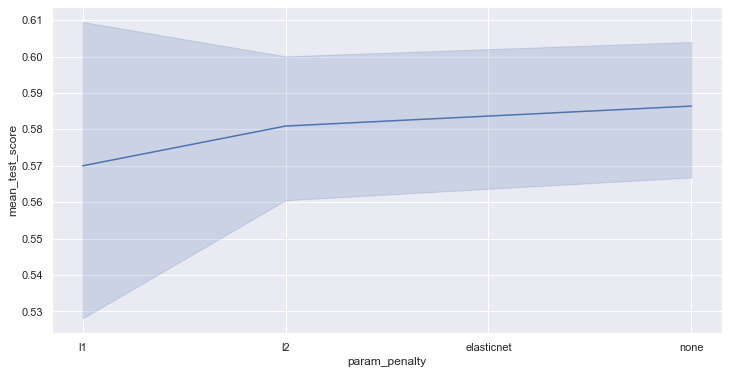

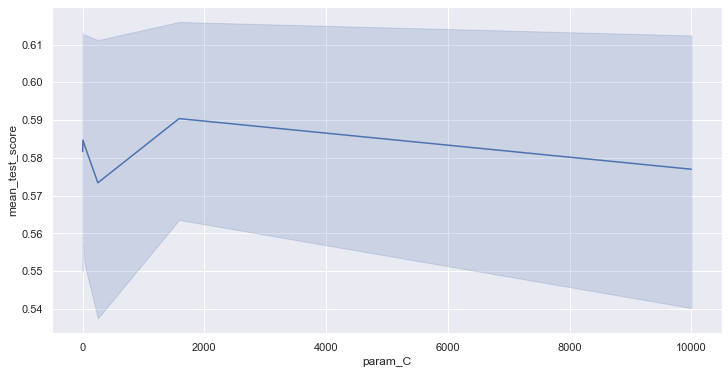

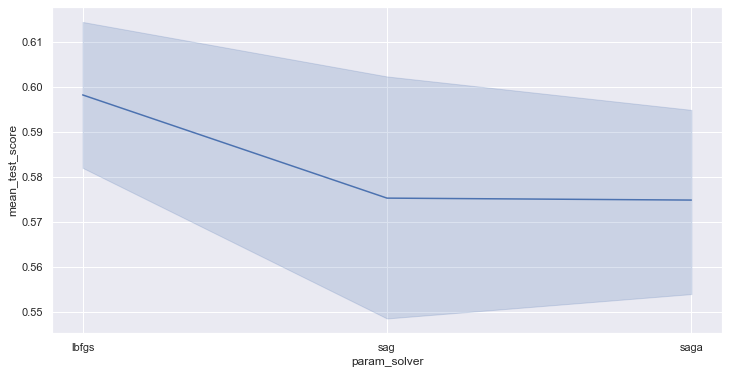

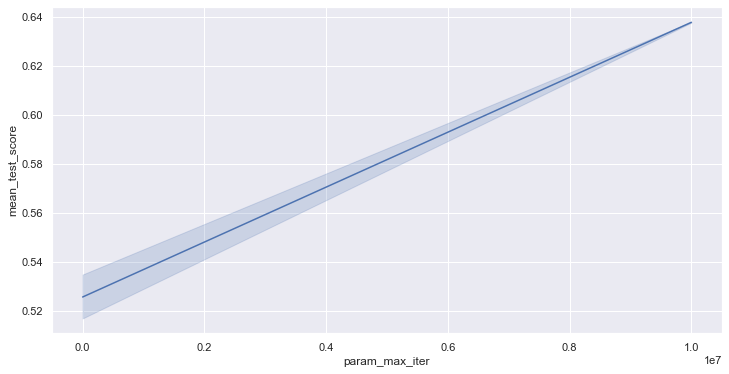

In [7]:
results = pd.DataFrame(best_model.cv_results_)
# plot the results of the penalty hyperparameter
sns.lineplot(x='param_penalty', y='mean_test_score', data=results)
#plt.savefig('LogisticPlots/penalty.jpg', dpi=1000)
plt.show()

# plot the results of the C hyperparameter
sns.lineplot(x='param_C', y='mean_test_score', data=results)
#plt.savefig('LogisticPlots/C.jpg', dpi=1000)
plt.show()

# plot the results of the solver hyperparameter
sns.lineplot(x='param_solver', y='mean_test_score', data=results)
#plt.savefig('LogisticPlots/solver.jpg', dpi=1000)
plt.show()

# plot the results of the max_iter hyperparameter
sns.lineplot(x='param_max_iter', y='mean_test_score', data=results)
#plt.savefig('LogisticPlots/max_iter.jpg', dpi=1000)
plt.show()

In [8]:
# evaluate the results of bestmodel
print(confusion_matrix(y_test, best_model.predict(X_test)))
print(accuracy_score(y_test, best_model.predict(X_test)))


[[235 213]
 [178 446]]
0.6352611940298507


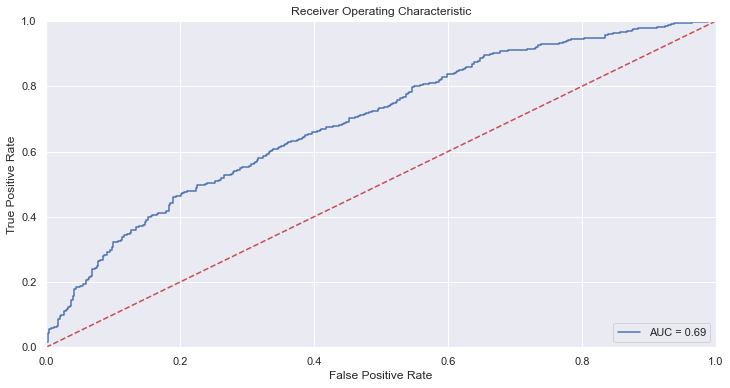

In [9]:
# plot the area under the curve for bestmodel
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# calculate the fpr and tpr for all thresholds of the classification
probs = best_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('LogisticPlots/ROC.jpg', dpi=1000)
plt.show()


In [10]:
# create a function that takes in df_full and a number, n of features, fits a random forest model, and returns the top n features
def top_features(n,df=df_full):
    np.random.seed(621)
    # create a list of the features that are all columns in df with "Avg"
    features = [col for col in df.columns if 'Avg' in col]
    # convert home_homeAvg and home_awayAvg to 1 if Y and 0 if N
    df['home_homeAvg'] = df['home_homeAvg'].apply(lambda x: 1 if x == 'Y' else 0)
    df['home_awayAvg'] = df['home_awayAvg'].apply(lambda x: 1 if x == 'Y' else 0)
    # do an 80/20 train test split
    train, test = train_test_split(df, test_size=0.2, random_state=101)
    # create a y variable with the winner column
    y = df['winner']
    X = df[features]
    y_train = train['winner']
    X_train = train[features]
    y_test = test['winner']
    X_test = test[features]
    # create a random forest model using the features list as the X and "winner" as the Y using sklearn
    rfmodel = RandomForestClassifier(n_estimators=100)
    rfmodel.fit(X_train, y_train)
    # make predictions
    predictions = rfmodel.predict(X_test)
    # evaluate the model
    #print(confusion_matrix(y_test, predictions))
    print(accuracy_score(y_test, predictions))
    # create a dataframe of the features and their importance
    feature_importance = pd.DataFrame(rfmodel.feature_importances_, index=X_train.columns, columns=['importance'])
    # sort the dataframe by importance
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    # return the top n features
    # create a list of the top n features
    top_features = feature_importance.head(n).index
    # using only the top_features, create a new X_train and X_test
    X_train = X_train[top_features]
    X_test = X_test[top_features]
    # create a new logistic regression model with max_iter = 10000000, L2 penalty, and C = 1, and sag solver
    max_iter = 10000000
    penalty = 'l2'
    C = 1
    solver = 'sag'
    logmodel = LogisticRegression(max_iter=max_iter, penalty=penalty, C=C, solver=solver)
    logmodel.fit(X_train, y_train)
    # make predictions
    predictions = logmodel.predict(X_test)
    # evaluate the model
    print(confusion_matrix(y_test, predictions))
    print(accuracy_score(y_test, predictions))
    return feature_importance.head(n), accuracy_score(y_test, predictions)


0.6147388059701493
[[180 281]
 [148 463]]
0.5998134328358209
0.6147388059701493
[[219 242]
 [152 459]]
0.6324626865671642
0.6147388059701493
[[217 244]
 [145 466]]
0.6371268656716418
0.6147388059701493
[[212 249]
 [146 465]]
0.6315298507462687
0.6147388059701493
[[211 250]
 [147 464]]
0.6296641791044776
0.6147388059701493
[[210 251]
 [147 464]]
0.628731343283582
0.6147388059701493
[[210 251]
 [146 465]]
0.6296641791044776
0.6147388059701493
[[209 252]
 [154 457]]
0.621268656716418
0.6147388059701493
[[205 256]
 [146 465]]
0.625
0.6147388059701493
[[207 254]
 [147 464]]
0.6259328358208955
0.6147388059701493
[[206 255]
 [147 464]]
0.625
0.6147388059701493
[[206 255]
 [146 465]]
0.6259328358208955
0.6147388059701493
[[208 253]
 [147 464]]
0.6268656716417911
0.6147388059701493
[[211 250]
 [146 465]]
0.6305970149253731
0.6147388059701493
[[212 249]
 [146 465]]
0.6315298507462687
0.6147388059701493
[[213 248]
 [145 466]]
0.6333955223880597
0.6147388059701493
[[213 248]
 [145 466]]
0.63339552

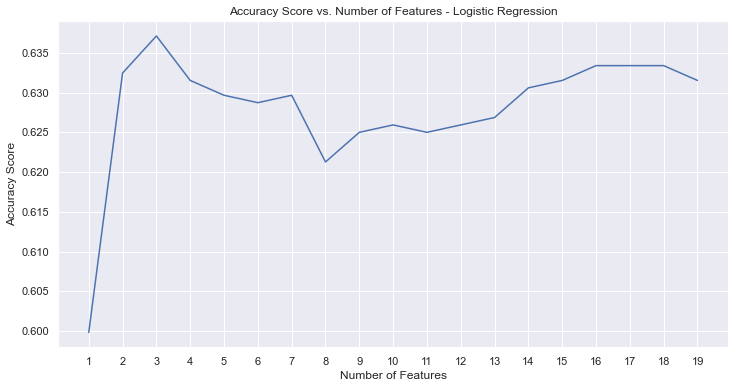

In [11]:
accuracy_scores = []
ns = []
for n in range(1, 20):
    ns.append(n)
    accuracy_scores.append(top_features(n)[1])

# plot the accuracy scores for each n
sns.lineplot(x=ns, y=accuracy_scores)
# label the plot
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs. Number of Features - Logistic Regression')
# report the best n and the best accuracy score on plot
# change the xticks to be the ns
plt.xticks(ns)
# save the plot
plt.savefig('LogisticPlots/accuracy_scores.jpg', dpi=1000)

0.6147388059701493
[[217 244]
 [145 466]]
0.6371268656716418


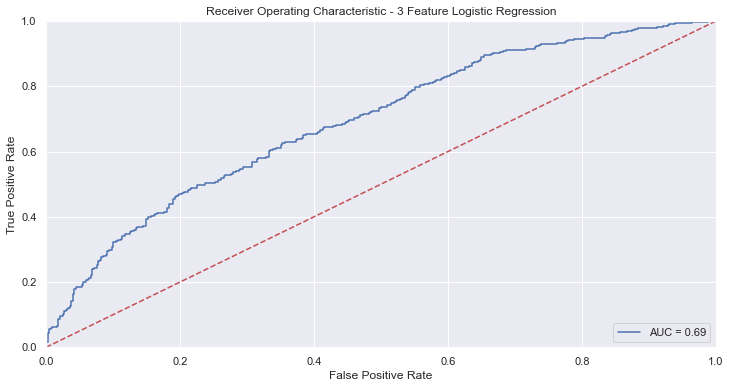

In [12]:
# from the logistic model with n=3, plot the auc curve
# calculate the fpr and tpr for all thresholds of the classification
# fit logmodel with the top 3 features
top_features(3)

probs = logmodel.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic - 3 Feature Logistic Regression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('LogisticPlots/ROC_3features.jpg', dpi=1000)


In [13]:
top_features(3)[0].index

0.6147388059701493
[[217 244]
 [145 466]]
0.6371268656716418


Index(['score_diff_homeAvg', 'score_diff_awayAvg', 'winner_awayAvg'], dtype='object')